[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Berry_1967/figs_5_8_10.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Berry_1967/figs_5_8_10.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Berry_1967/figs_5_8_10.ipynb)

#### based on Figs. 5, 8, & 10 from Berry 1967 (J. Atmos. Sci. 24)  "_Cloud Droplet Growth by Collection_"   
https://doi.org/10.1175/1520-0469(1967)024%3C0688:CDGBC%3E2.0.CO;2

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import os
from numpy import errstate
from PySDM.backends import CPU, GPU
from PySDM.dynamics.collisions.collision_kernels import Geometric, Hydrodynamic, Electric
from PySDM_examples.Berry_1967.spectrum_plotter import SpectrumPlotter
from PySDM_examples.Berry_1967.settings import Settings
from PySDM_examples.Shima_et_al_2009.example import run
from PySDM_examples.utils import widgets

In [3]:
progbar = widgets.IntProgress(min=0, max=100, description='%')

In [4]:
def demo(**kwargs):
    with kwargs['freezer']:
        with errstate(all='raise'):
            settings = Settings(steps=[i * (kwargs['n_step'] // kwargs['n_plot']) for i in range(kwargs['n_plot'] + 1)])
            backend = GPU if kwargs['gpu'] else CPU
            settings.n_sd = 2 ** kwargs['n_SD']
            settings.adaptive = kwargs['adaptive']
            settings.dt = 10 if settings.adaptive else settings.dt
            if kwargs['kernel'] == 'geometric sweep-out':
                settings.kernel = Geometric()
            elif kwargs['kernel'] == 'electric field 3000V/cm':
                settings.kernel = Electric()
            else:
                settings.kernel = Hydrodynamic()

            states, _ = run(settings, backend, (widgets.ProgbarUpdater(progbar, settings.output_steps[-1]),))

        with errstate(invalid='ignore'):
            plotter = SpectrumPlotter(settings)
            plotter.smooth = kwargs['smooth']
            for step, state in states.items():
                plotter.plot(state, step * settings.dt)
            plotter.show()

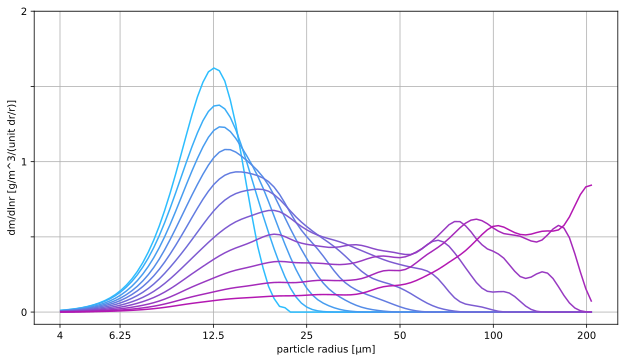

In [6]:
n_SD = widgets.IntSlider(value=14, min=12, max=18, step=1, description='$log_2(n_{SD})$', continuous_update=False)
n_step = widgets.IntSlider(value=1000, step=100, min=0, max=2400, description='$n_{step}$', continuous_update=False)
n_plot = widgets.IntSlider(value=10, step=1, min=1, max=16, description='$n_{plot}$', continuous_update=False)
sliders = widgets.HBox([n_SD, n_step, n_plot])

adaptive = widgets.Checkbox(value=False, description='adaptive dt')
smooth = widgets.Checkbox(value=True, description='smooth plot')
gpu = widgets.Checkbox(value=False, description='GPU')
options = [adaptive, smooth]
if GPU.ENABLE:
    options.append(gpu)
kernel = widgets.Select(
    options=['geometric sweep-out', 'electric field 3000V/cm', 'hydrodynamic capture'],
    value='geometric sweep-out',
    description='kernel:',
    rows=3
)
options.append(kernel)
boxes = widgets.HBox(options)
    
freezer = widgets.Freezer([n_SD, n_step, n_plot, kernel, adaptive, gpu])
inputs = {
    'freezer': freezer, 'n_SD': n_SD, 'n_step': n_step, 'n_plot': n_plot, 
    'kernel': kernel, 'adaptive': adaptive, 'smooth': smooth, 'gpu': gpu
}

if 'CI' not in os.environ:
    widgets.display(sliders, boxes, progbar, widgets.interactive_output(demo, inputs))
else:
    demo(**{k:v.value for k,v in inputs.items()})